In [2]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import tqdm
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vgg16


In [3]:
crop_size = 96
upscale_factor = 4
epochs = 20
batch_size = 64
root = Path('/home/noel/datasets/VOCdevkit/VOC2012')
train_data_dir = root / 'JPEGImages'


In [4]:
hr_transform = transforms.Compose([
    transforms.RandomCrop(crop_size),
    transforms.ToTensor()
])

lr_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
    transforms.ToTensor()
])

In [5]:
class BaseDataset(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor=None):
        super(BaseDataset, self).__init__()
        self.image_filenames = [os.path.join(dataset_dir, x) 
                                for x in os.listdir(dataset_dir) if self.is_image_file(x)]
        self.crop_size = crop_size
        self.upscale_factor = upscale_factor

    def load_image(self, index):
        return Image.open(self.image_filenames[index])

    def __len__(self):
        return len(self.image_filenames)

    def is_image_file(self, file_name):
        return any(file_name.endswith(ext) 
                   for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


class TrainDataset(BaseDataset):
    def __init__(self, hr_transform, lr_transform, dataset_dir, crop_size, upscale_factor):
        super(TrainDataset, self).__init__(dataset_dir, crop_size, upscale_factor)
        self.hr_transform = hr_transform
        self.lr_transform = lr_transform

    def __getitem__(self, index):
        hr_image = self.hr_transform(self.load_image(index))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

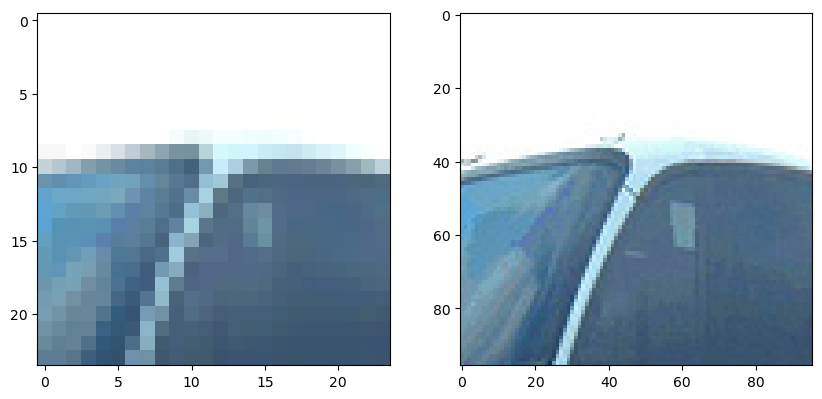

In [6]:
dataset = TrainDataset(hr_transform, lr_transform, train_data_dir, crop_size, upscale_factor)

hr, lr = dataset[0]

fig, axes = plt.subplots(1, 2, figsize = (10, 10))

axes[0].imshow(hr.permute(1, 2, 0))
axes[1].imshow(lr.permute(1, 2, 0))

In [7]:
hr, lr = dataset[0]
hr.shape, lr.shape

(torch.Size([3, 24, 24]), torch.Size([3, 96, 96]))

In [8]:
hr_size = set()
lr_size = set()
for hr, lr in dataset:
    hr_size.add(hr.shape)
    lr_size.add(lr.shape)
    
hr_size, lr_size

({torch.Size([3, 24, 24])}, {torch.Size([3, 96, 96])})

In [9]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=False)

![](https://raw.githubusercontent.com/crlotwhite/ML_Study/main/%EB%85%BC%EB%AC%B8%EA%B5%AC%ED%98%84/generative/assets/Cap%202024-08-15%2002-45-29-962.png)

In [10]:
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]


![](https://raw.githubusercontent.com/crlotwhite/ML_Study/main/%EB%85%BC%EB%AC%B8%EA%B5%AC%ED%98%84/generative/assets/Cap%202024-08-15%2002-43-50-138.png)

In [11]:
import torchvision

model = torchvision.models.vgg16(pretrained=True)
type(model.features)

/home/noel/miniconda3/envs/dl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/noel/miniconda3/envs/dl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.nn.modules.container.Sequential

In [12]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_net = nn.Sequential(*[
            vgg.features[:30]
        ]).eval()

        for params in loss_net.parameters():
            params.requires_grad = False

        self.loss_net = loss_net
        self.mse = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, D_out, fake_img, real_img):
        content_loss = self.mse(self.loss_net(fake_img), self.loss_net(real_img))
        adversarial_loss = torch.mean(1-D_out)
        perceptual_loss = content_loss * 0.006 + adversarial_loss * 0.001
        tv_loss = self.tv_loss(fake_img)

        return perceptual_loss + tv_loss * 2e-8



![image.png](https://raw.githubusercontent.com/crlotwhite/ML_Study/main/%EB%85%BC%EB%AC%B8%EA%B5%AC%ED%98%84/generative/assets/Cap%202024-08-15%2001-58-41-395.jpg)

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.model = nn.Sequential(*[
            nn.LazyConv2d(in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
            nn.LazyConv2d(in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        ])

    def forward(self, x):
        return self.model(x) + x

In [14]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBlock, self).__init__()
        
        self.model = nn.Sequential(*[
            nn.LazyConv2d(in_channels * up_scale ** 2, kernel_size=3, padding=1),
            nn.PixelShuffle(up_scale),
            nn.PReLU()
        ])

    def forward(self, x):
        return self.model(x)

In [15]:
import torch
import torch.nn as nn

model = nn.PixelShuffle(4)
x = torch.randn((64, 64, 24, 24))
model(x).shape

torch.Size([64, 4, 96, 96])

In [16]:
class Generator(nn.Module):
    def __init__(self, scale_factor):
        super(Generator, self).__init__()

        num_upsamples = int(math.log(scale_factor, 2))

        self.model = nn.Sequential(*[
            nn.LazyConv2d(64, kernel_size=9, padding=4),
            nn.PReLU(),
            *[
                ResidualBlock(64) for _ in range(5)
            ],
            nn.LazyConv2d(64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            *[
                UpsampleBlock(64, 2) for _ in range(num_upsamples)
            ],
            nn.LazyConv2d(3, kernel_size=9, padding=4),
            nn.Tanh()
        ])

    def forward(self, x):
        return (self.model(x) + 1) / 2

        

In [17]:
class Discriminator(nn.Module):
    class ConvBlock(nn.Module):
        def __init__(self, channels):
            super(Discriminator.ConvBlock, self).__init__()
            
            self.model = nn.Sequential(*[
                nn.LazyConv2d(channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(channels),
                nn.LeakyReLU(0.2),
                nn.LazyConv2d(channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(channels),
                nn.LeakyReLU(0.2)
            ])
        def forward(self, x):
            return self.model(x)
            
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(*[
            nn.LazyConv2d(64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.LazyConv2d(64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            *[
                Discriminator.ConvBlock(channels)
                for channels in [128, 256, 512]
            ],
            nn.AdaptiveAvgPool2d(1),
            nn.LazyConv2d(1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.LazyConv2d(1, kernel_size=1)
        ])

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.model(x).view(batch_size))

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator(4)
D = Discriminator()

G_loss = GeneratorLoss()

G.to(device)
D.to(device)

G_loss.to(device)

G_opt = optim.Adam(G.parameters())
D_opt = optim.Adam(D.parameters())


In [19]:
G_losses = []
D_losses = []

for epoch in range(1, epochs+1):
    pbar = tqdm.tqdm(train_loader)

    G.train()
    D.train()

    for lr_img, hr_img in pbar:
        lr_img = lr_img.to(device)
        hr_img = hr_img.to(device)

        # train D: max D(x) - 1 - D(G(z))
        fake_img = G(lr_img)
        
        D_opt.zero_grad()
        loss_D = D(hr_img).mean() - 1 + D(fake_img).mean()
        loss_D.backward(retain_graph=True)
        D_opt.step()

        # train G: min 1 - D(G(z)) + Content Loss + TV Loss
        G_opt.zero_grad()
        D_out = D(fake_img).mean()
        loss_G = G_loss(D_out, fake_img, hr_img)
        loss_G.backward()
        G_opt.step()

    G.eval()

    with torch.no_grad():
        vbar = tqdm.tqdm(val_loader)
        val_result = {'mse': 0, 'psnr': 0, 'batch_sizes': 0}

        for val_lr_img, val_hr_img in vbar:
            batch_size = val_lr_img.size(0)
            val_result['batch_sizes'] += batch_size

            val_lr_img = val_lr_img.to(device)
            val_hr_img = val_hr_img.to(device)

            val_sr_img = G(val_lr_img)

            batch_mse = ((val_sr_img - val_hr_img) ** 2).data.mean()
            val_result['mse'] += batch_mse * batch_size

            epsilon = 1e-8 
            try:
                val_result['psnr'] = 10 * math.log10((val_hr_img.max() ** 2) / ((val_result['mse'] + epsilon) / val_result['batch_sizes']))
            except:
                print(val_result)
        
        print(f'val score >> psnr: {val_result["psnr"]}')
            
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())

        

100%|██████████| 3425/3425 [00:15<00:00, 224.35it/s]


val score >> psnr: 0.302515387588485


100%|██████████| 3425/3425 [00:15<00:00, 215.61it/s]


val score >> psnr: 2.8007164155960815


100%|██████████| 3425/3425 [00:15<00:00, 222.66it/s]


val score >> psnr: 4.271873889501352


100%|██████████| 3425/3425 [00:15<00:00, 219.34it/s]


val score >> psnr: 5.432400287184567


100%|██████████| 3425/3425 [00:15<00:00, 220.73it/s]


val score >> psnr: 5.405755864203218


100%|██████████| 3425/3425 [00:15<00:00, 220.16it/s]


val score >> psnr: 3.437991462318719


100%|██████████| 3425/3425 [00:15<00:00, 223.44it/s]


val score >> psnr: 3.9570609179977847


100%|██████████| 3425/3425 [00:15<00:00, 216.32it/s]


val score >> psnr: 3.654535605444627


100%|██████████| 3425/3425 [00:15<00:00, 222.04it/s]


val score >> psnr: 4.979602830773414


100%|██████████| 3425/3425 [00:16<00:00, 211.91it/s]


val score >> psnr: 3.5186551217117747


100%|██████████| 3425/3425 [00:16<00:00, 209.29it/s]


val score >> psnr: 4.830206945340403


100%|██████████| 3425/3425 [00:16<00:00, 212.36it/s]


val score >> psnr: 5.001550505539503


100%|██████████| 3425/3425 [00:15<00:00, 219.67it/s]


val score >> psnr: 5.324286359750719


100%|██████████| 3425/3425 [00:15<00:00, 227.65it/s]


val score >> psnr: 4.110724522045183


100%|██████████| 3425/3425 [00:14<00:00, 231.47it/s]


val score >> psnr: 4.5595048443058666


100%|██████████| 3425/3425 [00:15<00:00, 222.78it/s]


val score >> psnr: 5.195215008942178


100%|██████████| 3425/3425 [00:15<00:00, 219.95it/s]


val score >> psnr: 5.157194121388764


100%|██████████| 3425/3425 [00:15<00:00, 226.02it/s]


val score >> psnr: 0.2247555709521437


100%|██████████| 3425/3425 [00:15<00:00, 222.59it/s]


val score >> psnr: 3.6821527009491497


100%|██████████| 3425/3425 [00:15<00:00, 220.53it/s]

val score >> psnr: 5.187023425801788


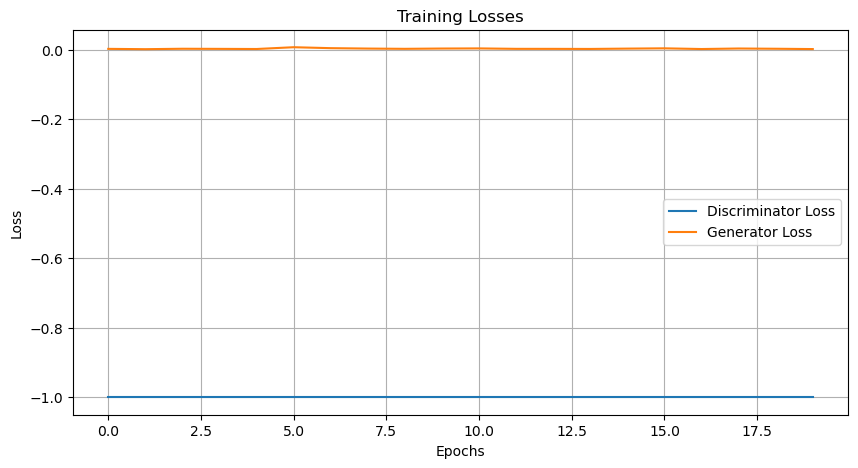

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(G_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

torch.Size([1, 3, 384, 400])


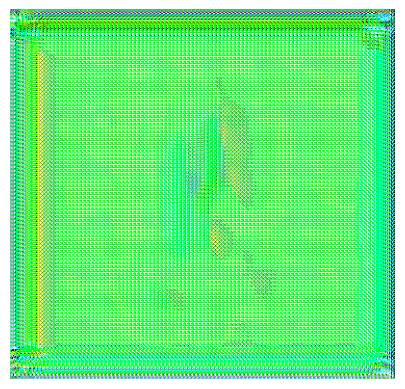

In [24]:
import time


test_path = Path('/home/noel/datasets/set5_set14/Set14/Set14')
model = G.eval()
image = Image.open(test_path / 'baboon.png')
image = transforms.Resize(96, interpolation=Image.BICUBIC)(image)
image = transforms.ToTensor()(image).unsqueeze(0).to(device)


start = time.time()
sr_img = G(image)
end = (time.time() - start)
print(sr_img.size())
sr_img = transforms.ToPILImage()(sr_img[0].data.cpu())

plt.imshow(sr_img)
plt.axis('off')  
plt.show()